In [1]:
%%capture
!pip install cython
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!cp /kaggle/input/rcnnutils/engine.py .
!cp /kaggle/input/rcnnutils/utils.py .
!cp /kaggle/input/rcnnutils/coco_eval.py .
!cp /kaggle/input/rcnnutils/coco_utils.py .
!cp /kaggle/input/rcnnutils/transforms.py .

In [2]:
import os
import ast
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2

import torch
from PIL import Image
from tqdm.auto import tqdm

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import utils
from engine import train_one_epoch, evaluate

In [3]:
# Constants
TEST_DIR = '/kaggle/input/global-wheat-detection/test'
BASE_DIR = '/kaggle/input/gwdaugmented/train'

In [4]:
train_df = pd.read_csv(os.path.join('/kaggle/input/gwdaugmented/', 'train.csv'))
train_df

image_id  x_min  y_min  x_max   y_max  width  height     area
0           b6ab77fd7  834.0  222.0  890.0   258.0   56.0    36.0   2016.0
1           b6ab77fd7  226.0  548.0  356.0   606.0  130.0    58.0   7540.0
2           b6ab77fd7  377.0  504.0  451.0   664.0   74.0   160.0  11840.0
3           b6ab77fd7  834.0   95.0  943.0   202.0  109.0   107.0  11663.0
4           b6ab77fd7   26.0  144.0  150.0   261.0  124.0   117.0  14508.0
...               ...    ...    ...    ...     ...    ...     ...      ...
295533  5e0747034_aug  876.0  310.0  960.0   405.0   84.0    95.0   7980.0
295534  5e0747034_aug  625.0  393.0  732.0   475.0  107.0    82.0   8774.0
295535  5e0747034_aug  749.0  725.0  890.0   796.0  141.0    71.0  10011.0
295536  5e0747034_aug  410.0  932.0  594.0  1011.0  184.0    79.0  14536.0
295537  5e0747034_aug   55.0  223.0  149.0   284.0   94.0    61.0   5734.0

[295538 rows x 8 columns]

In [5]:
class WheatDataset(Dataset):
    
    def __init__(self, df, transforms):
        self.df = df
        self.image_ids = train_df['image_id'].unique()
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(os.path.join(BASE_DIR, 'train', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # Convert from NHWC to NCHW as pytorch expects images in NCHW format
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image)
        
        # Get bbox coordinates for each wheat head(s)
        bboxes_df = self.df[self.df['image_id'] == image_id]
        boxes, areas = [], []
        n_objects = len(bboxes_df)  # Number of wheat heads in the given image

        for i in range(n_objects):
            x_min = bboxes_df.iloc[i]['x_min']
            x_max = bboxes_df.iloc[i]['x_max']
            y_min = bboxes_df.iloc[i]['y_min']
            y_max = bboxes_df.iloc[i]['y_max']

            boxes.append([x_min, y_min, x_max, y_max])
            areas.append(bboxes_df.iloc[i]['area'])

        boxes = torch.as_tensor(boxes, dtype=torch.int64)
        
        # Get the labels. We have only one class (wheat head)
        labels = torch.ones((n_objects, ), dtype=torch.int64)
        
        areas = torch.as_tensor(areas)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((n_objects, ), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([index]),
            'area': areas,
            'iscrowd': iscrowd
        }
        
        if self.transforms:
            result_aug = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = result_aug['image'].float()
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*result_aug['bboxes'])))).permute(1, 0)

        return image, target

In [6]:
def get_model(pre_trained=True):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pre_trained)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (wheat heads) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [7]:
%%capture
# get the model using our helper function
model = get_model()

In [8]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and wheat heads
num_classes = 2

# use our dataset and defined transformations
dataset = WheatDataset(train_df, None)
dataset_test = WheatDataset(train_df, None)

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=16, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.002,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 12 epochs
num_epochs = 12

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch: [0]  [  0/419]  eta: 1:13:54  lr: 0.000007  loss: 4.4243 (4.4243)  loss_classifier: 0.6175 (0.6175)  loss_box_reg: 0.3015 (0.3015)  loss_objectness: 3.2607 (3.2607)  loss_rpn_box_reg: 0.2447 (0.2447)  time: 10.5825  data: 6.5223  max mem: 11464
Epoch: [0]  [ 10/419]  eta: 0:20:17  lr: 0.000055  loss: 4.0949 (3.9103)  loss_classifier: 0.6202 (0.6208)  loss_box_reg: 0.3574 (0.3478)  loss_objectness: 2.8894 (2.7148)  loss_rpn_box_reg: 0.2226 (0.2269)  time: 2.9757  data: 0.7569  max mem: 11730
Epoch: [0]  [ 20/419]  eta: 0:17:03  lr: 0.000102  loss: 2.4628 (2.9018)  loss_classifier: 0.6177 (0.6139)  loss_box_reg: 0.4090 (0.3974)  loss_objectness: 1.2102 (1.6790)  loss_rpn_box_reg: 0.2002 (0.2115)  time: 2.1641  data: 0.1705  max mem: 11730
Epoch: [0]  [ 30/419]  eta: 0:15:36  lr: 0.000150  loss: 1.6569 (2.5016)  loss_classifier: 0.5863 (0.5963)  loss_box_reg: 0.4623 (0.4207)  loss_objectness: 0.4212 (1.2769)  loss_rpn_box_reg: 0.1937 (0.2077)  time: 2.0930  data: 0.1484  max mem: 1

In [9]:
!rm -rf *

In [10]:
torch.save(model.state_dict(), 'fasterrcnn_augmented_10.pth')

In [11]:
def get_bbox(bboxes, col, color='white'):
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (bboxes[i][0], bboxes[i][1]),
            bboxes[i][2] - bboxes[i][0], 
            bboxes[i][3] - bboxes[i][1], 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

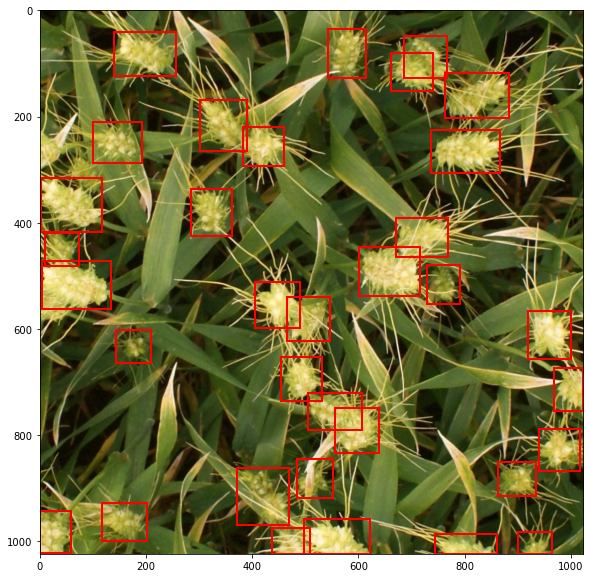

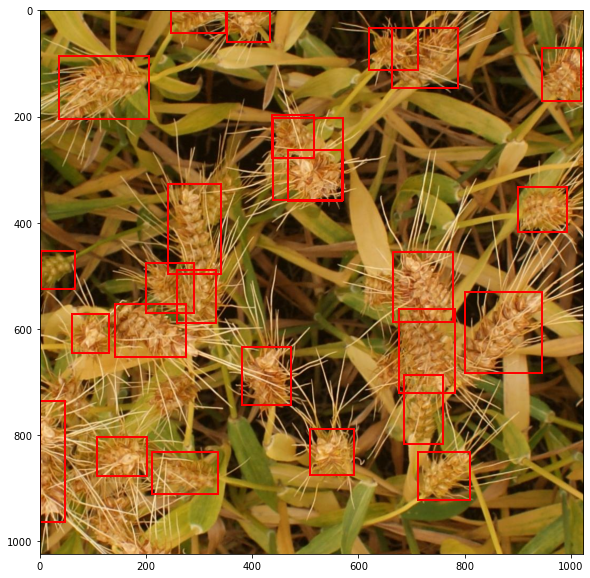

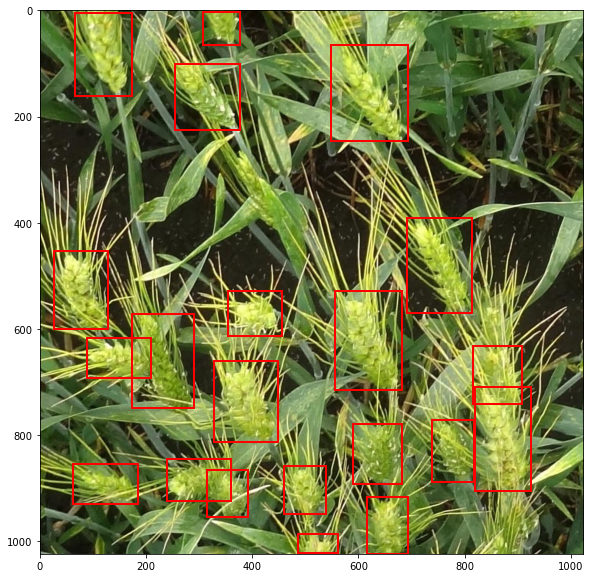

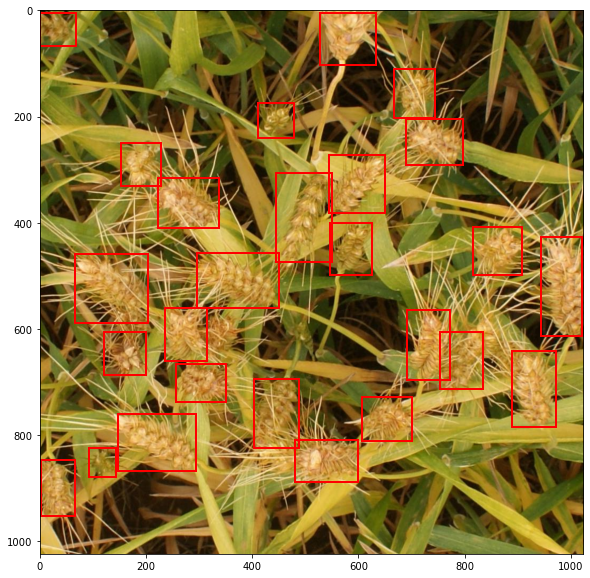

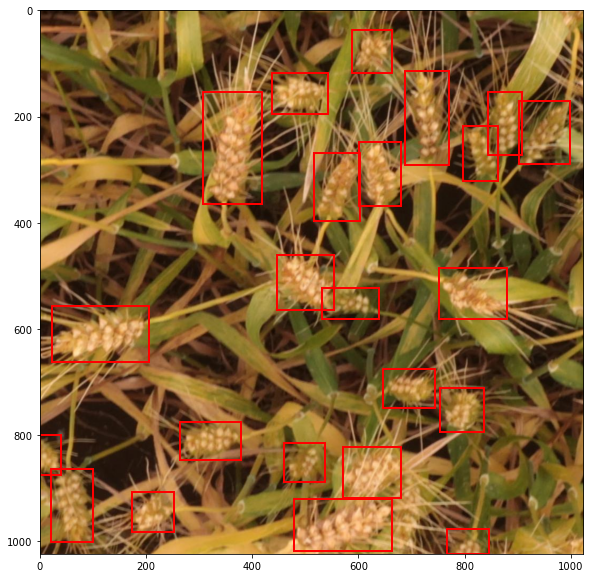

In [12]:
for img in os.listdir(TEST_DIR)[:5]:
    image = cv2.imread(os.path.join(TEST_DIR, img), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    preds = model([torch.from_numpy(np.transpose(image, (2, 0, 1))).to(device)])[0]
    
    pred_bboxes = preds['boxes'].cpu().detach().numpy()
    pred_scores = preds['scores'].cpu().detach().numpy()
    
    mask = pred_scores >= 0.4
    pred_scores = pred_scores[mask]
    pred_bboxes = pred_bboxes[mask]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    get_bbox(pred_bboxes, ax, color='red')
    ax.imshow(image)